In [1]:
import xarray as xr
import cftime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import logging
import cartopy.crs as ccrs
import metpy  
import calendar
import argparse
import glob

In [2]:
# from dask.distributed import Client
# client = Client()
# # client

# import dask
# import dask.dataframe as dd

In [2]:
print(os.getcwd())

os.chdir('/group/moniergrp/TEM/')

print(os.getcwd()) 


/home/smmrrr/TEM_Analysis
/group/moniergrp/TEM


In [3]:
output_paths = glob.glob('output/IGSM-CAM_windDrnd10_CS2p5_Fae-0p55_Kz0p05_bau_lulcc_RCP8.5_0.5x0.5_1870-2100/*/*.GL*')
##get list of TEM output

input_paths = glob.glob('climate/IGSM-CAM_windDrnd10_CS2p5_Fae-0p55_Kz0p05_bau/*.gl[0-9]*')
##get list of TEM input


[]

In [4]:
## get parallel run group and variable info

output_group = [re.findall('GL[0-9]+$', w) for w in output_paths]
output_group = [item for sublist in output_group for item in sublist]

input_group = [re.findall('gl[0-9]+$', w) for w in input_paths]
input_group = [item.upper() for sublist in input_group for item in sublist]

input_var = [re.findall('prec|nirr|tair|aot40', w) for w in input_paths]
input_var = [item for sublist in input_var for item in sublist]


# np.concatenate([np.array(input_paths),np.array(input_group), np.array(input_var)])

In [5]:
#make tables with the relevant read in info

input_data = pd.DataFrame(
{'input_paths': input_paths,
'input_group': input_group,
 'input_var': input_var
}
)

output_data = pd.DataFrame(
{'output_paths': output_paths,
'output_group': output_group
}
)

In [6]:

input_data = pd.pivot(input_data, index = 'input_group', columns = 'input_var', values = 'input_paths').reset_index()

read_in_data = input_data.merge(output_data, left_on = 'input_group', right_on = 'output_group')

In [204]:
# read_in_data

In [7]:

output_col_names = ['lon'
,'lat'
,'variable'
,'cohort_number'
,'stand_age'
,'potential_veg'
,'current_veg'
,'subtype'
,'community_type'
,'lc_state'
,'silt_clay'
,'QC_Value'
,'land_area'
,'cohort_area'
,'year'
,'annual_sum'
,'monthly_maximum'
,'monthly_mean'
,'monthly_minimum'
,'Jan'
,'Feb'
,'Mar'
,'Apr'
,'May'
,'Jun'
,'Jul'
,'Aug'
,'Sep'
,'Oct'
,'Nov'
,'Dec'
,'region']

input_col_names = ["lon", 'lat','var' ,'Area', 'year', 'sum', 'max', 'average'
         , 'min', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'
         , 'Nov', 'Dec', 'Area_Name']

In [10]:
i = 0  
print(len(read_in_data))
ouput_data_path = '/home/smmrrr/TEM_Analysis/'
ouput_data_path+'merged_dataset'+read_in_data.loc[i, 'output_group']+'.csv'

40


'/home/smmrrr/TEM_Analysis/merged_datasetGL01.csv'

In [11]:
## TEM PFT info
forest_vegs = [9, 4, 16, 33, 19, 10 ]
forest_veg_names = ['needle-leaf evergreen temperate','boreal','broadleaved evergreen tree tropical'
                   ,'broadleaved evergreen tree temperate','broadleaved deciduous tree tropical'
                   ,'broadleaved deciduous tree temperate']


ouput_data_path = '/home/smmrrr/TEM_Analysis'

# for i in range(len(read_in_data)):
for i in range(11, len(read_in_data)):

###read in cohort output
    cohort_output = pd.read_csv(read_in_data.loc[i, 'output_paths']
                , names = output_col_names)

    ##read in precipitation files
    prec = pd.read_csv(read_in_data.loc[i, 'prec']
               , names = input_col_names)
    aot40 = pd.read_csv(read_in_data.loc[i, 'aot40']
               , names = input_col_names)
    nirr = pd.read_csv(read_in_data.loc[i, 'nirr']
               , names = input_col_names)
    tair = pd.read_csv(read_in_data.loc[i, 'tair']
               , names = input_col_names)


    ## shape input datasets wide to long
    prec = pd.melt(prec, id_vars = ['lon','lat', 'Area', 'year'], value_vars = [
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'], 
             var_name='month', value_name='prec'
            ,col_level=0)

    aot40 = pd.melt(aot40, id_vars = ['lon','lat', 'Area', 'year'], value_vars = [
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'], 
             var_name='month', value_name='aot40'
            ,col_level=0)

    nirr = pd.melt(nirr, id_vars = ['lon','lat', 'Area', 'year'], value_vars = [
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'], 
             var_name='month', value_name='nirr'
            ,col_level=0)

    tair = pd.melt(tair, id_vars = ['lon','lat', 'Area', 'year'], value_vars = [
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'], 
             var_name='month', value_name='tair'
            ,col_level=0)

    ##merge climate variables together
    climate_vars = prec.merge(
                aot40,on = ['lon','lat', 'Area', 'year', 'month']
                ).merge(
                tair ,on = ['lon','lat', 'Area', 'year', 'month']                           
                ).merge(
                nirr ,on = ['lon','lat', 'Area', 'year', 'month']                           
                )

    ##subset to forest veg types 
    cohort_output = cohort_output.loc[cohort_output['current_veg'].isin(forest_vegs)] 

    ##melt cohort output
    cohort_output = pd.melt(cohort_output, id_vars = ['lon','lat', 'cohort_area', 'land_area', 'year', 'current_veg', 'stand_age'], value_vars = [
    'Jan',
    'Feb',
    'Mar',
    'Apr',
    'May',
    'Jun',
    'Jul',
    'Aug',
    'Sep',
    'Oct',
    'Nov',
    'Dec'], 
             var_name='month', value_name='NCE'
            ,col_level=0)


    agg_cohort_output = cohort_output.merge(
                climate_vars, how = 'left'
        ,on = ['lon','lat', 'year', 'month']
                )



    wm_cohort = lambda x: np.average(x, weights=agg_cohort_output.loc[x.index, "cohort_area"])  # https://stackoverflow.com/questions/31521027/groupby-weighted-average-and-sum-in-pandas-dataframe
    wm_land_area = lambda x: np.average(x, weights=agg_cohort_output.loc[x.index, "Area"])  # https://stackoverflow.com/questions/31521027/groupby-weighted-average-and-sum-in-pandas-dataframe
    ##need to improve this to be funciton of dataset, weighted index

    agg_cohort_output.to_csv(ouput_data_path+'merged_dataset_'+read_in_data.loc[i, 'output_group']+'.csv', index=False)

    final_output = agg_cohort_output.groupby([
        'current_veg', 'stand_age']).agg(cohort_area=('cohort_area', 'sum'), total_area=('Area', 'sum'),
                                                                              NCE_weighted=('NCE', wm_cohort), 
                                                                           prec = ('prec', wm_land_area),
                                                                           aot40 = ('aot40', wm_land_area),
                                                                           tair = ('tair', wm_land_area),
                                                                           nirr = ('nirr', wm_land_area)
                                                                                   )


    final_output.to_csv(ouput_data_path+'summarized_by_standage_'+read_in_data.loc[i, 'output_group']+'.csv')

    print(i)


11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [205]:

# cohort_output.loc[1]

In [206]:
# prec.loc[1]

In [135]:
print(climate_vars.count())
print(prec.count())

lon      1392000
lat      1392000
Area     1392000
year     1392000
month    1392000
prec     1392000
aot40    1392000
tair     1392000
nirr     1392000
dtype: int64
lon      1392000
lat      1392000
Area     1392000
year     1392000
month    1392000
prec     1392000
dtype: int64


In [124]:
print(cohort_output['current_veg'].unique())

cohort_output.count()


[12  0 22  2 15 33  8  1  7 11 31 21]


lon                35029882
lat                35029882
variable           35029882
cohort_number      35029882
stand_age          35029882
potential_veg      35029882
current_veg        35029882
subtype            35029882
community_type     35029882
lc_state           35029882
silt_clay          35029882
QC_Value           35029882
land_area          35029882
cohort_area        35029882
year               35029882
annual_sum         35029882
monthly_maximum    35029882
monthly_mean       35029882
monthly_minimum    35029882
jan                35029882
feb                35029882
mar                35029882
apr                35029882
may                35029882
jun                35029882
jul                35029882
aug                35029882
sep                35029882
oct                35029882
nov                35029882
dec                35029882
region             35029882
dtype: int64

In [131]:
cohort_output = cohort_output.loc[cohort_output['current_veg'].isin(forest_vegs)] 
cohort_output.count()


lon                2937756
lat                2937756
variable           2937756
cohort_number      2937756
stand_age          2937756
potential_veg      2937756
current_veg        2937756
subtype            2937756
community_type     2937756
lc_state           2937756
silt_clay          2937756
QC_Value           2937756
land_area          2937756
cohort_area        2937756
year               2937756
annual_sum         2937756
monthly_maximum    2937756
monthly_mean       2937756
monthly_minimum    2937756
jan                2937756
feb                2937756
mar                2937756
apr                2937756
may                2937756
jun                2937756
jul                2937756
aug                2937756
sep                2937756
oct                2937756
nov                2937756
dec                2937756
region             2937756
dtype: int64

In [163]:
cohort_output = pd.melt(cohort_output, id_vars = ['lon','lat', 'cohort_area', 'land_area', 'year', 'current_veg', 'stand_age'], value_vars = [
'jan'
,'feb'
,'mar'
,'apr'
,'may'
,'jun'
,'jul'
,'aug'
,'sep'
,'oct'
,'nov'
,'dec'], 
         var_name='month', value_name='NCE'
        ,col_level=0)

In [171]:
# cohort_output[['lat', 'lon', 'stand_age', 'current_veg', 'year', 'month']].value_counts()
# max(cohort_output.groupby(['lat', 'lon'])['land_area'].nunique() )

1

In [203]:

# wm_cohort = lambda x: np.average(x, weights=cohort_output.loc[x.index, "cohort_area"])  # https://stackoverflow.com/questions/31521027/groupby-weighted-average-and-sum-in-pandas-dataframe
# wm_land_area = lambda x: np.average(x, weights=cohort_output.loc[x.index, "Area"])  # https://stackoverflow.com/questions/31521027/groupby-weighted-average-and-sum-in-pandas-dataframe


# agg_cohort_output = cohort_output.groupby(['lon','lat', 'land_area', 'year', 'current_veg', 'stand_age', 'month']).agg(cohort_area=('cohort_area', 'sum'),
#                                                                           NCE_weighted=('NCE', wm_cohort))
# agg_cohort_output.count()



In [181]:
cohort_output.count()

lon            35253072
lat            35253072
cohort_area    35253072
land_area      35253072
year           35253072
current_veg    35253072
stand_age      35253072
month          35253072
NCE            35253072
dtype: int64

In [185]:
# print(agg_cohort_output.NCE_weighted.describe())
# print(cohort_output.NCE.describe())
# cohort_output['month'] = cohort_output['month'].str.title()

In [186]:
agg_cohort_output = cohort_output.merge(
            climate_vars, how = 'left'
    ,on = ['lon','lat', 'year', 'month']
            )

agg_cohort_output.count()

lon            35253072
lat            35253072
cohort_area    35253072
land_area      35253072
year           35253072
current_veg    35253072
stand_age      35253072
month          35253072
NCE            35253072
Area           35253072
prec           35253072
aot40          35253072
tair           35253072
nirr           35253072
dtype: int64

In [187]:
agg_cohort_output['area_dif'] = agg_cohort_output['land_area'] - agg_cohort_output['Area']

agg_cohort_output['area_dif'].describe()


count    3.525307e+07
mean    -2.891931e+01
std      1.085037e+02
min     -1.001000e+03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      0.000000e+00
Name: area_dif, dtype: float64

In [193]:

wm_cohort = lambda x: np.average(x, weights=agg_cohort_output.loc[x.index, "cohort_area"])  # https://stackoverflow.com/questions/31521027/groupby-weighted-average-and-sum-in-pandas-dataframe
wm_land_area = lambda x: np.average(x, weights=agg_cohort_output.loc[x.index, "Area"])  # https://stackoverflow.com/questions/31521027/groupby-weighted-average-and-sum-in-pandas-dataframe
##need to improve this to be funciton of dataset, weighted index

final_output = agg_cohort_output.groupby([
    'current_veg', 'stand_age']).agg(cohort_area=('cohort_area', 'sum'), total_area=('Area', 'sum'),
                                                                          NCE_weighted=('NCE', wm_cohort), 
                                                                       prec = ('prec', wm_land_area),
                                                                       aot40 = ('aot40', wm_land_area),
                                                                       tair = ('tair', wm_land_area),
                                                                       nirr = ('nirr', wm_land_area)
                                                                               )

In [191]:
final_output.describe()

,cohort_area,NCE_weighted,prec,aot40,tair,nirr
count,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000
mean,74908.043321,-0.501918,66.482800,4073.262104,10.719566,127.368294
std,78975.363324,5.560464,9.480388,3123.908742,2.753813,14.745260
min,60.000000,-139.916494,32.776921,0.000000,5.344606,91.461296
25%,17670.000000,-0.252939,60.578535,1056.018385,8.887326,120.975205
50%,40620.000000,-0.022408,65.167171,3517.543304,10.425528,126.932551
75%,104688.000000,0.236991,70.316826,6633.049823,12.542450,137.210588
max,260964.000000,10.219124,96.719989,10481.841501,18.612185,174.135299


In [197]:
final_output = final_output.reset_index()

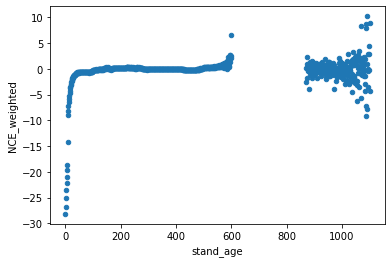

In [199]:
final_output.loc[final_output['NCE_weighted'] > -100].plot(x = 'stand_age', y = 'NCE_weighted', kind = 'scatter')

plt.show()
                  

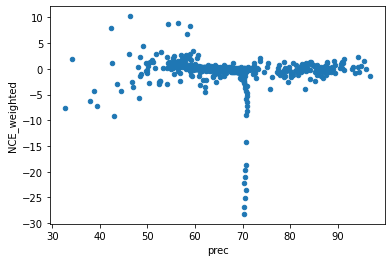

In [200]:
final_output.loc[final_output['NCE_weighted'] > -100].plot(x = 'prec', y = 'NCE_weighted', kind = 'scatter')

plt.show()

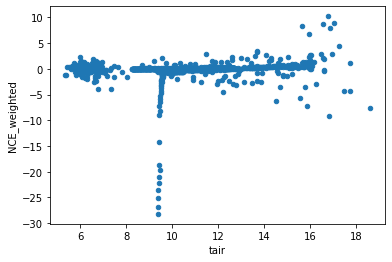

In [201]:
final_output.loc[final_output['NCE_weighted'] > -100].plot(x = 'tair', y = 'NCE_weighted', kind = 'scatter')

plt.show()

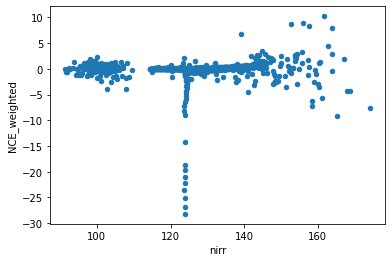

In [202]:
final_output.loc[final_output['NCE_weighted'] > -100].plot(x = 'nirr', y = 'NCE_weighted', kind = 'scatter')

plt.show()

In [162]:
# cohort_output.loc[(cohort_output['lat'] == 49.5) & 
#                  (cohort_output['lon'] == 15.0) &
#                   (cohort_output['stand_age'] == 130)  &
#                   (cohort_output['current_veg'] == 33)  &
#                   (cohort_output['year'] == 2072)                   
#               ]

,lon,lat,variable,cohort_number,stand_age,potential_veg,current_veg,subtype,community_type,lc_state,...,apr,may,jun,jul,aug,sep,oct,nov,dec,region
29980668,15.0,49.5,NCE,202,130,7,33,7,6,2,...,6.7,-6.3,-35.6,17.9,1.6,3.0,5.0,7.5,-1.0,EET
29980669,15.0,49.5,NCE,203,130,7,33,7,6,2,...,11.0,-6.1,-40.3,21.1,3.3,4.7,6.7,9.4,-4.2,EET
29980670,15.0,49.5,NCE,204,130,7,33,7,6,2,...,6.6,-6.3,-35.5,17.9,1.6,3.0,5.0,7.5,-1.0,EET
29980671,15.0,49.5,NCE,205,130,7,33,7,6,2,...,6.6,-6.3,-35.5,17.9,1.6,3.0,4.9,7.5,-1.0,EET
29980672,15.0,49.5,NCE,206,130,7,33,7,6,2,...,6.4,-6.3,-35.4,17.8,1.6,2.9,4.9,7.4,-0.9,EET
29980673,15.0,49.5,NCE,207,130,7,33,7,6,2,...,6.4,-6.3,-35.4,17.8,1.6,2.9,4.9,7.4,-0.9,EET
29980674,15.0,49.5,NCE,208,130,7,33,7,6,2,...,6.5,-6.3,-35.4,17.8,1.6,3.0,4.9,7.5,-0.9,EET
29980675,15.0,49.5,NCE,209,130,7,33,7,6,2,...,11.0,-6.1,-40.2,21.1,3.2,4.6,6.7,9.4,-4.2,EET
29980676,15.0,49.5,NCE,210,130,7,33,7,6,2,...,6.4,-6.3,-35.3,17.7,1.5,2.9,4.9,7.4,-0.9,EET
29980677,15.0,49.5,NCE,211,130,7,33,7,6,2,...,6.2,-6.4,-35.2,17.7,1.5,2.9,4.8,7.4,-0.8,EET


In [146]:
# print(cohort_output.lat.unique())
# print(climate_vars.lat.unique())
# print(cohort_output[['lat', 'lon']].describe())
# print(climate_vars[['lat', 'lon']].describe())



[59.5 60.  60.5 61.  61.5 58.5 59.  62.  58.  62.5 55.5 56.  56.5 63.
 54.5 55.  63.5 57.  64.  64.5 57.5 50.  65.  49.5 65.5 49.  66.  45.
 45.5 46.  66.5 48.5 50.5 51.5 52.  52.5 53.  53.5 67.  44.  44.5 51.
 67.5 43.5 54. ]
[65.  65.5 66.  66.5 67.  67.5 68.  68.5 71.  64.5 64.  59.5 60.  60.5
 61.  61.5 58.5 59.  62.  58.  62.5 55.5 56.  56.5 63.  54.5 55.  63.5
 57.  57.5 50.  49.5 49.  45.  45.5 46.  48.5 50.5 51.5 52.  52.5 53.
 53.5 44.  44.5 51.  43.5 54. ]
                lat           lon
count  2.937756e+06  2.937756e+06
mean   5.129337e+01  1.357725e+01
std    4.776875e+00  2.235652e+00
min    4.350000e+01  5.000000e+00
25%    4.850000e+01  1.300000e+01
50%    5.050000e+01  1.450000e+01
75%    5.550000e+01  1.500000e+01
max    6.750000e+01  1.550000e+01
                lat           lon
count  1.392000e+06  1.392000e+06
mean   6.020600e+01 -2.622900e+01
std    5.647529e+00  7.551772e+01
min    4.350000e+01 -1.800000e+02
25%    5.750000e+01  6.500000e+00
50%    6.100000e+01

In [45]:
##take subset of cohort output

###melt the dataset


In [ ]:
##merge to precip data 



In [ ]:
cohort_output.groupby(
    ['site'])['transition_10_rising'].transform('mean')